In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision import transforms

from random import random
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from datetime import datetime 
from celluloid import Camera
from IPython.display import HTML

## Parameter

In [2]:
batch_size = 1
n_epochs = 200
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
lambda_cyc = 10

In [3]:
cuda = True if torch.cuda.is_available() else False
cuda

True

## Dataset

In [4]:
class Facade(Dataset):
  def __init__(self, path, transform = None):
    self.filenames = glob(path + '/*.jpg')
    self.transform = transform
  
  def __getitem__(self, idx):
    photoname = self.filenames[idx]
    sketchname = self.filenames[idx][:-3] + 'png'
    photo = Image.open(photoname).convert('RGB')
    sketch = Image.open(sketchname).convert('RGB')
    
    if self.transform:
      photo = self.transform(photo)
      sketch = self.transform(sketch)
    
    return photo, sketch, (photoname, sketchname)
  
  def __len__(self):
    return len(self.filenames)

In [5]:
data_path = './Facade'

transform = transforms.Compose([
  transforms.Resize((256, 256)),
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset_Facade = Facade(path = data_path,
                        transform=transform)

dataloader = DataLoader(dataset=dataset_Facade,
                        batch_size=batch_size,
                        shuffle=True)

In [6]:
photo, sketch, file_names = next(iter(dataloader))

In [7]:
file_names

[('./Facade\\cmp_b0135.jpg',), ('./Facade\\cmp_b0135.png',)]

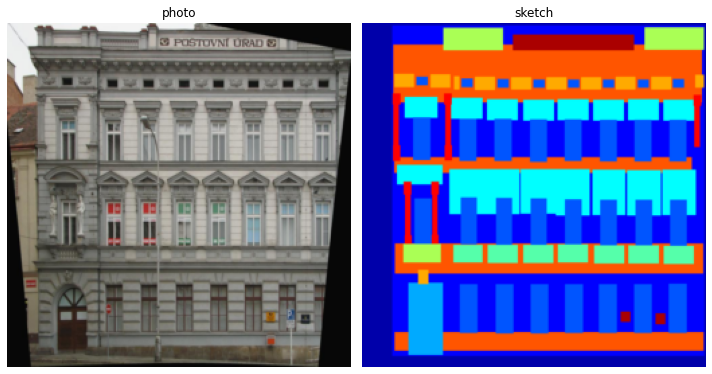

In [8]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(transforms.functional.to_pil_image(0.5 * photo[0] + 0.5))
plt.title('photo')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transforms.functional.to_pil_image(0.5 * sketch[0] + 0.5))
plt.title('sketch')
plt.axis('off')

plt.tight_layout()
plt.savefig('./history/data.png', dpi=300)
plt.show()

## Model

In [9]:
def init_weight(module):
    classname = module.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(module.weight, mean=0.0, std=0.02)

In [10]:
class XK(nn.Module):
  def __init__(self, in_feature, out_feature, name, drop=False):
    super(XK, self).__init__()

    if name == 'ck':
      conv = nn.Conv2d(in_feature, out_feature, kernel_size=7, stride=1, padding=3, padding_mode='reflect')

    elif name == 'dk':
      conv = nn.Conv2d(in_feature, out_feature, kernel_size=3, stride=2, padding=1, padding_mode='reflect')
      
    elif name == 'Rk':
      conv = nn.Conv2d(in_feature, out_feature, kernel_size=3, padding=1, padding_mode='reflect')

    elif name == 'uk':
      conv = nn.ConvTranspose2d(in_feature, out_feature, kernel_size=3, stride=2, padding=1, output_padding=1)
    else:
      raise Exception('Check name')
    
    norm = nn.InstanceNorm2d(out_feature)
    relu = nn.ReLU()
    model = [conv, norm, relu]

    if name == 'Rk':
      model += [conv, norm, relu]
    if drop:
      model = [conv]
      
    self.model = nn.Sequential(*model)

  def forward(self, x):
    return self.model(x)

In [11]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    
    self.model = nn.Sequential(
      XK(3, 64, name='ck'),
      XK(64, 128, name='dk'),
      XK(128, 256, name='dk'),
      XK(256, 256, name='Rk'),
      XK(256, 256, name='Rk'),
      XK(256, 256, name='Rk'),
      XK(256, 256, name='Rk'),
      XK(256, 256, name='Rk'),
      XK(256, 256, name='Rk'),
      XK(256, 256, name='Rk'),
      XK(256, 256, name='Rk'),
      XK(256, 256, name='Rk'),
      XK(256, 128, name='uk'),
      XK(128, 64, name='uk'),
      XK(64, 3, name='ck', drop=True), 
      nn.Tanh()
    )
    
  def forward(self, x):
    return self.model(x)

In [12]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(256),
        nn.LeakyReLU(0.2),
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(512),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(512, 1, kernel_size=4, stride=4, dilation=3),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

In [13]:
generator_G = Generator()
generator_F = Generator()
discriminator_X = Discriminator()
discriminator_Y = Discriminator()

generator_G.apply(init_weight)
generator_F.apply(init_weight)
discriminator_X.apply(init_weight)
discriminator_Y.apply(init_weight)

generator_G.cuda()
generator_F.cuda()
discriminator_X.cuda()
discriminator_Y.cuda()

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): ConvTranspose2d(512, 1, kernel_size=(4, 4), stride=(4, 4), dilation=(3, 3))
    (12): Sigmoid()
  )
)

In [14]:
from torchsummary import summary
summary(discriminator_X, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-7          [-1, 256, 32, 32]               0
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,664
   InstanceNorm2d-10          [-1, 512, 16, 16]               0
        LeakyReLU-11          [-1, 512, 16, 16]               0
  ConvTranspose2d-12            [-1, 1, 70, 70]           8,193
          Sigmoid-13            [-1, 1, 70, 70]               0
Total params: 2,764,737
Trainable param

## Train

In [15]:
class Buffer():
  def __init__(self):
    self.history = []

  def insert(self, x):
    if len(self.history) < 50:
      self.history.append(x)
    else:
      idx = int(random() * 50)
      self.history[idx] = x
  
  def sampling(self, image):
    if len(self.history) == 0:
      return image
    
    idx = int(random() * len(self.history))
    return torch.cat((image, self.history[idx]), dim=0)
  
  def __len__(self):
    return len(self.history)

In [16]:
history = {'G': [], 'D_X': [], 'D_Y': []}
history_loss = [0, 0, 0]
history_image = []
history_lr = []
len_loader = len(dataloader)

sketch = sketch.cuda()
ones = torch.ones(2, 1, 70, 70).cuda()
ones.requires_grad = False
zeros = torch.zeros(2, 1, 70, 70).cuda()
zeros.requires_grad = False

buffer_X = Buffer()
buffer_Y = Buffer()

In [17]:
optimizer_G_G = torch.optim.Adam(generator_G.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_G_F = torch.optim.Adam(generator_F.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D_X = torch.optim.Adam(discriminator_X.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D_Y = torch.optim.Adam(discriminator_Y.parameters(), lr=lr, betas=(beta1, beta2))

scheduler_lambda = lambda x: 0.95 ** (x-99) if x > 99 else 1
scheduler_G_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G_G, lr_lambda=scheduler_lambda)
scheduler_G_F = torch.optim.lr_scheduler.LambdaLR(optimizer_G_F, lr_lambda=scheduler_lambda)
scheduler_D_X = torch.optim.lr_scheduler.LambdaLR(optimizer_D_X, lr_lambda=scheduler_lambda)
scheduler_D_Y = torch.optim.lr_scheduler.LambdaLR(optimizer_D_Y, lr_lambda=scheduler_lambda)

loss_lse = nn.MSELoss().cuda()
loss_l1 = nn.L1Loss().cuda()

In [18]:
for epoch in range(n_epochs):
  time_start = datetime.now()
  history_loss = [0, 0, 0]
  generator_G.train()
  
  for photos, sketches, _ in dataloader:
    photos = photos.cuda()
    sketches = sketches.cuda()

    '''
    Discriminator
    '''
    optimizer_D_X.zero_grad()
    optimizer_D_Y.zero_grad()

    # generate fake
    fake_X = generator_F(photos).detach() # buffer로 들어가 다시 사용될 수 있으므로 detach해 추적을 막아주어야 한다.
    fake_Y = generator_G(sketches).detach()

    # classify real data
    d_real_X = discriminator_X(sketches)
    d_real_Y = discriminator_Y(photos)

    # classify fake data
    d_fake_X = discriminator_X(buffer_X.sampling(fake_X))
    d_fake_Y = discriminator_Y(buffer_Y.sampling(fake_Y))
    
    # loss
    loss_X = (loss_lse(d_real_X, ones) + loss_lse(d_fake_X, zeros)) / 2
    loss_Y = (loss_lse(d_real_Y, ones) + loss_lse(d_fake_Y, zeros)) / 2
    history_loss[1] += loss_X.item()
    history_loss[2] += loss_Y.item()
    
    # buffer insert
    buffer_X.insert(fake_X)
    buffer_Y.insert(fake_Y)
    
    # update
    loss_X.backward()
    loss_Y.backward()
    optimizer_D_X.step()
    optimizer_D_Y.step()

    '''
    Generator
    '''
    optimizer_G_G.zero_grad()
    optimizer_G_F.zero_grad()

    # generate real
    fake_Y = generator_G(sketches)
    fake_X = generator_F(photos)

    # classify fake
    d_fake_X = discriminator_X(fake_X)
    d_fake_Y = discriminator_Y(fake_Y)

    # loss(gan)
    loss_gan = (loss_lse(d_fake_X, ones) + loss_lse(d_fake_Y, ones))

    # loss(cycle)
    F_G_X = generator_F(fake_Y) # for forward cyc
    G_F_Y = generator_G(fake_X) # for backward cyc

    loss_cyc = loss_l1(sketches, F_G_X) + loss_l1(photos, G_F_Y)

    loss_G = loss_gan + loss_cyc * lambda_cyc
    history_loss[0] += loss_G.item()
      
    # update
    loss_G.backward()
    optimizer_G_G.step()
    optimizer_G_F.step()
    
  '''
  scheduler step
  '''
  scheduler_D_X.step()
  scheduler_D_Y.step()
  scheduler_G_G.step()
  scheduler_G_F.step()

  '''
  History
  '''
  time_end = datetime.now() - time_start
  
  loss = [history_loss[0]/len_loader, history_loss[1]/len_loader, history_loss[2]/len_loader]
  history['G'].append(loss[0])
  history['D_X'].append(loss[1])
  history['D_Y'].append(loss[2])
  history_lr.append(optimizer_G_G.param_groups[0]["lr"])
  
  generator_G.eval()
  with torch.no_grad():
    test = generator_G(sketch)[0].detach().cpu()
    test = transforms.functional.to_pil_image(0.5 * test + 0.5)
    history_image.append(test)
    test.save('./history/test/' + str(epoch).zfill(3) + '.png')
  
  print('%2dM %2dS / Epoch %2d' %(*divmod(time_end.seconds, 60), (epoch+1)))
  print('loss_G: %.5f, loss_D_X: %.5f, loss_D_Y: %.5f' %(loss[0], loss[1], loss[2]))

c:\users\solee\python3.8\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([2, 1, 70, 70])) that is different to the input size (torch.Size([1, 1, 70, 70])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 2M  3S / Epoch  1
loss_G: 9.23072, loss_D_X: 0.11152, loss_D_Y: 0.17076
 2M  4S / Epoch  2
loss_G: 7.15338, loss_D_X: 0.10551, loss_D_Y: 0.13177
 2M  4S / Epoch  3
loss_G: 6.13633, loss_D_X: 0.13904, loss_D_Y: 0.14236
 2M  4S / Epoch  4
loss_G: 5.85744, loss_D_X: 0.10374, loss_D_Y: 0.14576
 2M  4S / Epoch  5
loss_G: 5.57959, loss_D_X: 0.09772, loss_D_Y: 0.14013
 2M  4S / Epoch  6
loss_G: 5.56998, loss_D_X: 0.09619, loss_D_Y: 0.13590
 2M  4S / Epoch  7
loss_G: 5.81981, loss_D_X: 0.07828, loss_D_Y: 0.12426
 2M  4S / Epoch  8
loss_G: 5.24342, loss_D_X: 0.08673, loss_D_Y: 0.13068
 2M  4S / Epoch  9
loss_G: 6.16122, loss_D_X: 0.06484, loss_D_Y: 0.10559
 2M  4S / Epoch 10
loss_G: 5.82174, loss_D_X: 0.06445, loss_D_Y: 0.10019
 2M  4S / Epoch 11
loss_G: 5.40457, loss_D_X: 0.06230, loss_D_Y: 0.11211
 2M  4S / Epoch 12
loss_G: 5.29797, loss_D_X: 0.05989, loss_D_Y: 0.12024
 2M  4S / Epoch 13
loss_G: 5.13362, loss_D_X: 0.06856, loss_D_Y: 0.12525
 2M  4S / Epoch 14
loss_G: 5.04721, loss_D_X: 0.092

## History

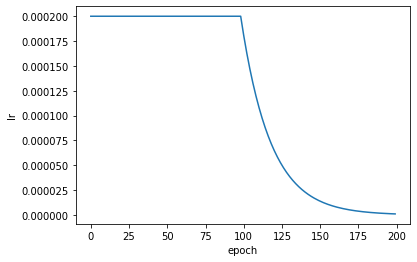

In [19]:
# history_lr
plt.xlabel('epoch')
plt.ylabel('lr')
plt.plot(range(n_epochs), history_lr)

plt.savefig('./history/history_lr.png', dpi=300)
plt.show()

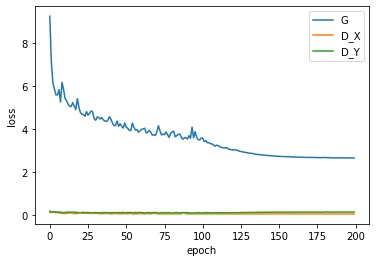

In [20]:
# history_loss
plt.plot(range(n_epochs), history['G'])
plt.plot(range(n_epochs), history['D_X'])
plt.plot(range(n_epochs), history['D_Y'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['G', 'D_X', 'D_Y'])

plt.savefig('./history/history_loss.png', dpi=300)
plt.show()

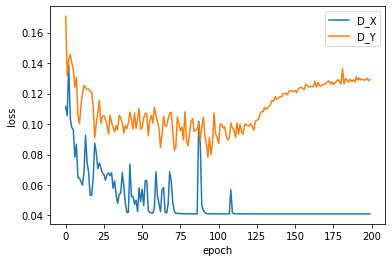

In [21]:
# history_loss(D)
plt.plot(range(n_epochs), history['D_X'])
plt.plot(range(n_epochs), history['D_Y'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['D_X', 'D_Y'])

plt.savefig('./history/history_loss_D.png', dpi=300)
plt.show()

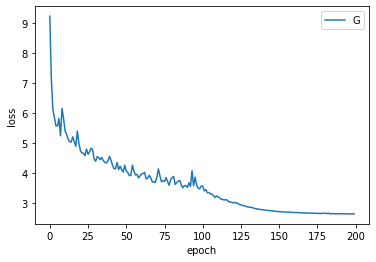

In [22]:
# history_loss(G)
plt.plot(range(n_epochs), history['G'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['G'])

plt.savefig('./history/history_loss_G.png', dpi=300)
plt.show()

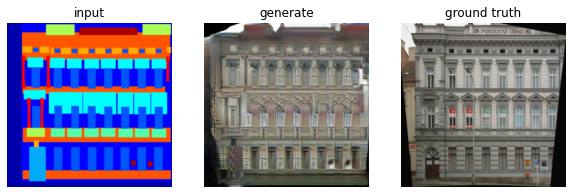

In [24]:
# history_image / photo, gen_sketch, sketch
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax1, ax2, ax3 = axes
camera = Camera(fig)

# sketch = sketch[0].detach().cpu()
sketch = transforms.functional.to_pil_image(0.5 * sketch + 0.5)
photo = transforms.functional.to_pil_image(0.5 * photo[0] + 0.5)

for epoch in range(n_epochs):
  ax1.axis('off')
  ax1.set_title('input')
  ax1.imshow(sketch)

  ax2.axis('off')
  ax2.set_title('generate')
  ax2.imshow(history_image[epoch])

  ax3.axis('off')
  ax3.set_title('ground truth')
  ax3.imshow(photo)

  camera.snap()

animation = camera.animate(interval=100)
animation.save('./history/history_image.mp4', dpi=300)

HTML(animation.to_html5_video())

## Result

In [25]:
transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [43]:
filename = 'cmp_x0220'
t_photo = Image.open('./test/' + filename + '.jpg').convert('RGB')
t_sketch = Image.open('./test/' + filename + '.png').convert('RGB')
t_photo = transform_test(t_photo).unsqueeze(dim=0)
t_sketch = transform_test(t_sketch).unsqueeze(dim=0)

In [44]:
r_photo = generator_G(t_sketch.cuda())
t_sketch = t_sketch.cpu()

In [45]:
r_photo = r_photo[0].detach().cpu()
r_photo = transforms.functional.to_pil_image(0.5 * r_photo + 0.5)

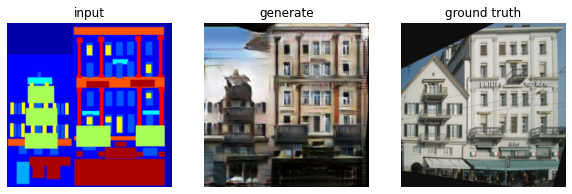

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax1, ax2, ax3 = axes

ax1.axis('off')
ax1.set_title('input')
ax1.imshow(transforms.functional.to_pil_image(0.5 * t_sketch[0] + 0.5))

ax2.axis('off')
ax2.set_title('generate')
ax2.imshow(r_photo)

ax3.axis('off')
ax3.set_title('ground truth')
ax3.imshow(transforms.functional.to_pil_image(0.5 * t_photo[0] + 0.5))

plt.savefig('./history/generator_G' + filename + '.png', dpi=300)
plt.show()

In [47]:
r_sketch = generator_F(t_photo.cuda())
t_photo = t_photo.cpu()

In [48]:
r_sketch = r_sketch[0].detach().cpu()
r_sketch = transforms.functional.to_pil_image(0.5 * r_sketch + 0.5)

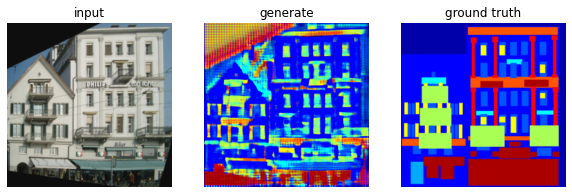

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax1, ax2, ax3 = axes

ax1.axis('off')
ax1.set_title('input')
ax1.imshow(transforms.functional.to_pil_image(0.5 * t_photo[0] + 0.5))

ax2.axis('off')
ax2.set_title('generate')
ax2.imshow(r_sketch)

ax3.axis('off')
ax3.set_title('ground truth')
ax3.imshow(transforms.functional.to_pil_image(0.5 * t_sketch[0] + 0.5))

plt.savefig('./history/generator_F.png', dpi=300)
plt.show()

## Save

In [33]:
# save
torch.save(generator_G.state_dict(), './history/generator_G.pt')
torch.save(generator_F.state_dict(), './history/generator_F.pt')